In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.constants as const
from uncertainties import ufloat
from uncertainties import unumpy as unp
import uncertainties

In [13]:
fringe_data = pd.read_csv('fringe_data_7_11.csv')
print(fringe_data)

        Record Length          10000   Points  -100.0000015E-3  \
0     Sample Interval  19.9999995E-6        s         -0.09998   
1       Trigger Point   5.00000044E3  Samples         -0.09996   
2                 NaN            NaN      NaN         -0.09994   
3                 NaN            NaN      NaN         -0.09992   
4                 NaN            NaN      NaN         -0.09990   
...               ...            ...      ...              ...   
9994              NaN            NaN      NaN          0.09990   
9995              NaN            NaN      NaN          0.09992   
9996              NaN            NaN      NaN          0.09994   
9997              NaN            NaN      NaN          0.09996   
9998              NaN            NaN      NaN          0.09998   

      548.000037670E-3  Unnamed: 5  Record Length.1        10000.1 Points.1  \
0                0.540         NaN  Sample Interval  19.9999995E-6        s   
1                0.532         NaN    Trigger Poi

In [14]:
# channel 2

time_ch2 = fringe_data['-100.0000015E-3']
voltage_ch2 = fringe_data['720.000028610E-3']

# channel 1

time_ch1 = fringe_data['-100.0000015E-3']
voltage_ch1 = fringe_data['548.000037670E-3']

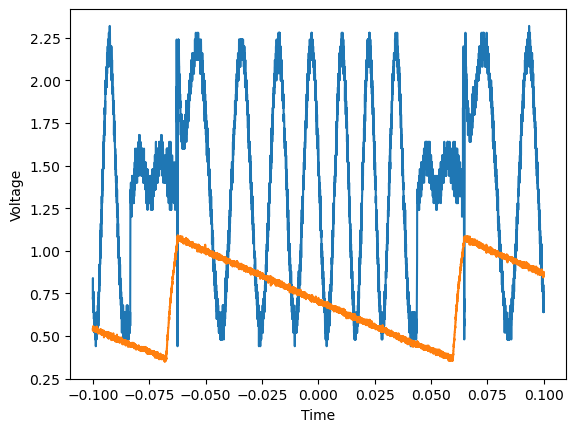

In [15]:
plt.plot(time_ch2, voltage_ch2)
plt.plot(time_ch1, voltage_ch1)

plt.xlabel('Time')
plt.ylabel('Voltage')

plt.show()

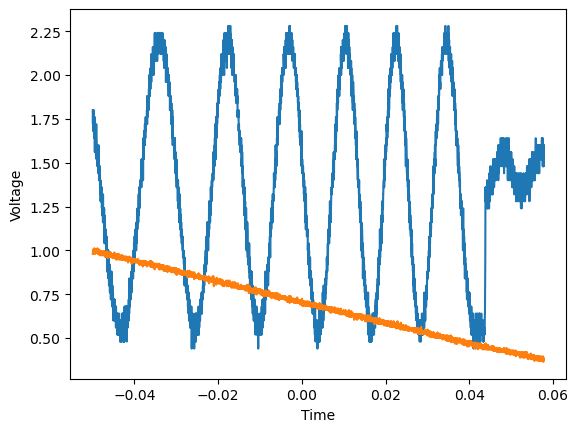

In [16]:
#truncate the data, using only the last 90% of the voltage sawtooth decrease

#remove the first part of the voltage data until we reach 95% of the max, this ensures next time the data decreases below 90% it is the begginng of the sawtooth decline
ch1_v_max=np.max(voltage_ch1)
first_cutoff_index=np.argmax(voltage_ch1>ch1_v_max*0.95)
trunc_voltage_ch1=voltage_ch1[first_cutoff_index::]

#remove the first part of the truncated voltage data until we descend below 90% of the max
start_index=np.argmax(trunc_voltage_ch1<=ch1_v_max*0.90)

#now assuming we only have one cycle, the minimum value should be the end of our descent so we can remove anything after it
end_index=np.argmin(trunc_voltage_ch1)

#now we can truncate all the data, we need to remeber the offset of the indeces caused by the first trunctation
trunc_voltage_ch1=trunc_voltage_ch1[start_index:end_index]
trunc_time_ch1=time_ch1[start_index+first_cutoff_index:end_index+first_cutoff_index]
trunc_time_ch2=time_ch2[start_index+first_cutoff_index:end_index+first_cutoff_index]
trunc_voltage_ch2=voltage_ch2[start_index+first_cutoff_index:end_index+first_cutoff_index]

plt.plot(trunc_time_ch2, trunc_voltage_ch2)
plt.plot(trunc_time_ch1, trunc_voltage_ch1)

plt.xlabel('Time')
plt.ylabel('Voltage')

plt.show()


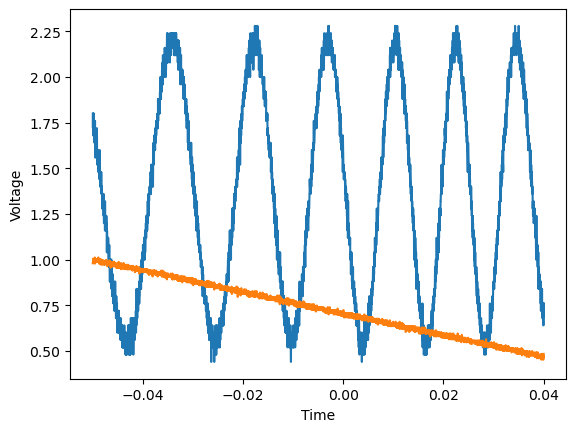

In [17]:
#TEMPORARY
#their is clearly something gong on after t=0.04 not sure what maby thier is some mode hopping maby their is an offset between the time measured on the two channels i dont know
#so im just going to remove it by hand for now
#have also reomved the first part of the data becuase the period is changing maby we need a diferent fitting function if the period is not uniform, like a sine of a polynomial or something 

temp_last_index=np.argmax(trunc_time_ch1>=0.04)
temp_first_index=0#np.argmax(trunc_time_ch1>=-0.01)

trunc_time_ch1=trunc_time_ch1[temp_first_index:temp_last_index]
trunc_time_ch2=trunc_time_ch2[temp_first_index:temp_last_index]
trunc_voltage_ch1=trunc_voltage_ch1[temp_first_index:temp_last_index]
trunc_voltage_ch2=trunc_voltage_ch2[temp_first_index:temp_last_index]

plt.plot(trunc_time_ch2, trunc_voltage_ch2)
plt.plot(trunc_time_ch1, trunc_voltage_ch1)

plt.xlabel('Time')
plt.ylabel('Voltage')

plt.show()



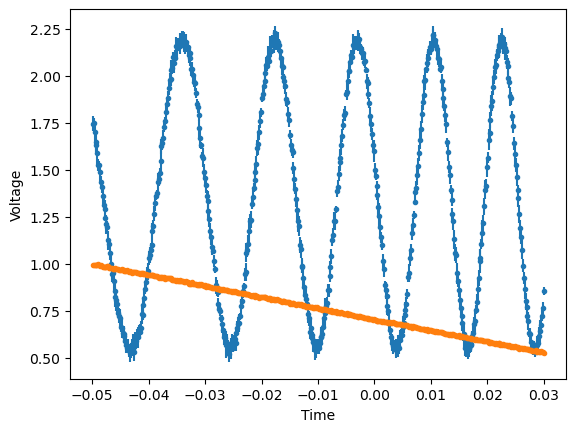

In [57]:
#calculate error on points by grouping points and using mean and standard deviation

#work out group sizes
N_groups=500
group_step_ch1=(trunc_time_ch1.size)//N_groups
group_step_ch2=(trunc_time_ch2.size)//N_groups

mean_times_ch1=np.zeros(N_groups)
mean_times_ch2=np.zeros(N_groups)
mean_voltages_ch1=np.zeros(N_groups)
mean_voltages_ch2=np.zeros(N_groups)
std_voltages_ch1=np.zeros(N_groups)
std_voltages_ch2=np.zeros(N_groups)

for i in range(N_groups):
	mean_times_ch1[i]=np.mean(np.array(trunc_time_ch1[i*group_step_ch1:(i+1)*group_step_ch1]))
	mean_times_ch2[i]=np.mean(np.array(trunc_time_ch2[i*group_step_ch1:(i+1)*group_step_ch1]))
	mean_voltages_ch1[i]=np.mean(np.array(trunc_voltage_ch1[i*group_step_ch1:(i+1)*group_step_ch1]))
	mean_voltages_ch2[i]=np.mean(np.array(trunc_voltage_ch2[i*group_step_ch1:(i+1)*group_step_ch1]))
	std_voltages_ch1[i]=np.std(np.array(trunc_voltage_ch1[i*group_step_ch1:(i+1)*group_step_ch1]))
	std_voltages_ch2[i]=np.std(np.array(trunc_voltage_ch2[i*group_step_ch1:(i+1)*group_step_ch1]))


plt.errorbar(mean_times_ch2, mean_voltages_ch2,yerr=std_voltages_ch2,linestyle="",marker='.')
plt.errorbar(mean_times_ch1, mean_voltages_ch1,yerr=std_voltages_ch1,linestyle="",marker='.')


plt.xlabel('Time')
plt.ylabel('Voltage')

plt.show()


0.014453729943+/-0.000000000025
[0.01445373 0.61034212 1.29825493 2.74257313]
reduces chi squared: 14.006475373272204


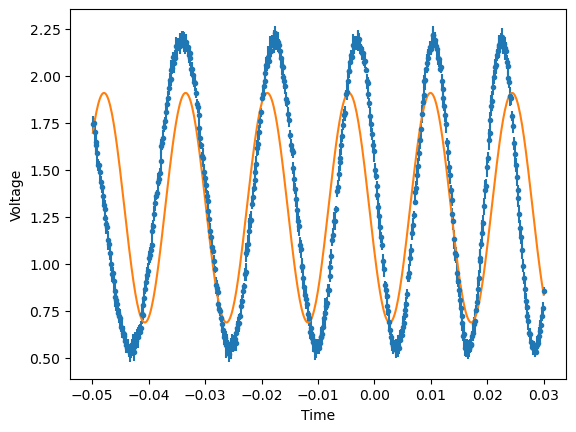

In [58]:
#sinusoidal fit of the chanel 2 voltage to find the period

def sinusoidal(time,period,amplitude,offset,phase):
	return amplitude*np.sin(2*np.pi*(time/period)-phase)+offset

popt,pcov,=curve_fit(
	f=sinusoidal,
	xdata=mean_times_ch2,
	ydata=mean_voltages_ch2,
	p0=(0.013, 0.85, 1.32, 3.3),
	#bounds=([-np.inf,0.8,1.2,0],[np.inf,0.9,1.4,2*np.pi]),
	sigma=std_voltages_ch2,
	absolute_sigma=True
)

period=ufloat(popt[0],pcov[0,0])
print(period)

print(popt)

voltage_fit_ch2=sinusoidal(mean_times_ch2,*popt)

def reduced_chi_squared(expected_values,observed_values,errors,dof):
	return np.sum(((observed_values-expected_values)**2)/(errors**2))/dof

print("reduces chi squared:",reduced_chi_squared(voltage_fit_ch2,mean_voltages_ch2,std_voltages_ch2, trunc_voltage_ch2.size-np.size(popt)))

plt.errorbar(mean_times_ch2, mean_voltages_ch2,yerr=std_voltages_ch2,linestyle="",marker='.')
plt.plot(mean_times_ch2, voltage_fit_ch2,color='C1')
#plt.plot(mean_times_ch2,sinusoidal(mean_times_ch2,0.013, 0.85, 1.32, 3.3),color='C2')

plt.xlabel('Time')
plt.ylabel('Voltage')

plt.show()